### Problem Statement:
 You are given a dataset of Kannada digits, and the goal is to classify these digits into one of ten classes. Kannada is a language spoken in southwestern India, and the dataset contains handwritten Kannada digits.

## Project Procedure:
### Install necessary libraries:



In [8]:
# Step 2: Install necessary libraries
!pip install -r requirements.txt

### Load the neccessary libraries:

In [30]:

# Step 3: Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, confusion_matrix, roc_auc_score, classification_report
)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
from mlflow.sklearn import log_model
from mlflow.tracking import MlflowClient
from pyngrok import ngrok
import time



### Data Loading:

 Extract the dataset from the NPZ file, which contains the training and testing images along with their labels.

In [31]:

# Step 4: Define a function to load data from NPZ files
def load_data(file_path):
    data = np.load(file_path)
    return data["arr_0"]

# Step 5: Load Kannada MNIST dataset
train_file_path = 'data/X_kannada_MNIST_train.npz'
label_train_file_path = 'data/y_kannada_MNIST_train.npz'
test_file_path = 'data/X_kannada_MNIST_test.npz'
label_test_file_path = 'data/y_kannada_MNIST_test.npz'

X_train = load_data(train_file_path)
X_test = load_data(test_file_path)
y_train = load_data(label_train_file_path)
y_test = load_data(label_test_file_path)


## Dataset:

The dataset consists of 60,000 images for training and 10,000 images for testing.
Each image is in grayscale and has a size of 28x28 pixels.

In [32]:
# Step 6: Display dataset information
print('Training data shape:', X_train.shape)
print('Test data shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('Prediction y_test shape:', y_test.shape)
data_size_and_shape = (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Training data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)
y_train shape: (60000,)
Prediction y_test shape: (10000,)


### Sample image:
visualize the first image in the dataset

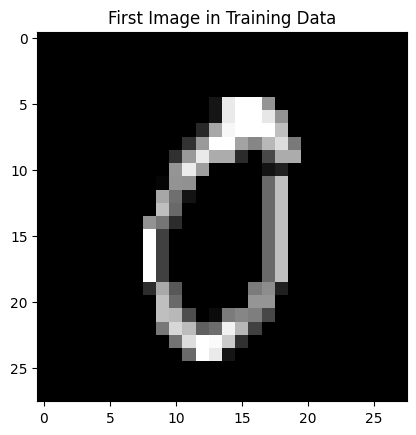

Shape of the image: (28, 28)


In [12]:
# Step 7: Visualize sample image
plt.imshow(X_train[0], cmap='gray')
plt.title('First Image in Training Data')
plt.show()
print('Shape of the image:', X_train[0].shape)

## Sample image:
visualize the first 10  images in the dataset

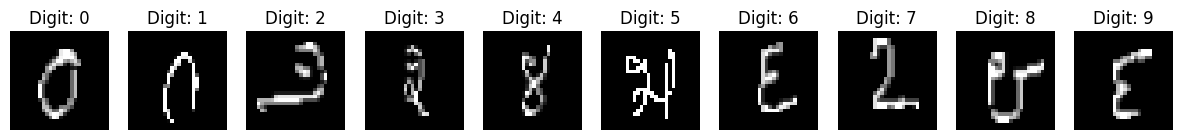

In [13]:

# Display the first 10 images side by side
num_images_to_display = 10
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 3))
for i in range(num_images_to_display):
    axes[i].imshow(X_train[i], cmap='gray')
    axes[i].set_title(f'Digit: {y_train[i]}')
    axes[i].axis('off')
plt.show()

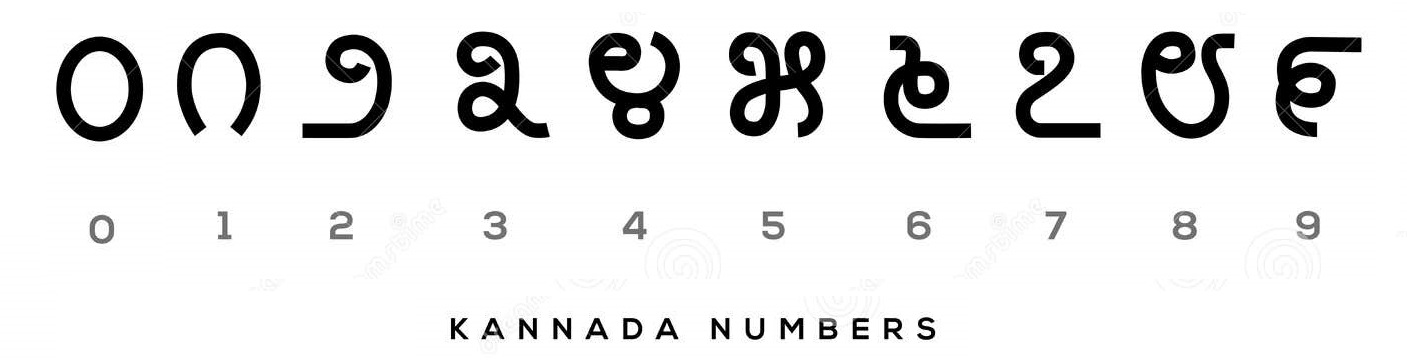

### Sampling the data


In [33]:

# Split the data into training (5000 samples) and testing (500 samples)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=5000, test_size=500,)

## Data Preprocessing:
### Flattening the data:


*   used to flatten the data into a 1D array which can be processed by the machine learning models.
*   1D array can be used as input for the machine learning models to avoid dimensionality issues .

In [34]:
# Step 8: Flatten the image data
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)


standardization needs to be done separately on train and test to avoid data leakage, resemble real-world usage, achieve robust scaling, scaling helps machine learning algorithms train faster, perform better, and operate more efficiently

In [18]:
# # Step 3: Data Preprocessing
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

### Ploting Visualisations to understand the nature of the data

1. **`plot_roc_curves` Function:**
   This function is designed to plot Receiver Operating Characteristic (ROC) curves for each class in a multi-class classification model.The function generates a plot showing ROC curves for each class, along with the corresponding AUC scores. The plot is saved as an image file.

2. **`plot_confusion_matrix` Function:**

   The function generates a heatmap representing the confusion matrix, with annotations showing the count of true positive, true negative, false positive, and false negative predictions. The plot is saved as an image file.


In [35]:

# Function to plot ROC curves
def plot_roc_curves(roc_auc_data, clf_name, n_components):

    plt.figure(figsize=(8, 6))
    for i in range(roc_auc_data["n_classes"]):
        plt.plot(
            roc_auc_data["fpr"][i],
            roc_auc_data["tpr"][i],
            label=f'Class {roc_auc_data["class_names"][i]} (AUC = {roc_auc_data["roc_auc"][i]:.2f})',
        )
    plt.plot([0, 1], [0, 1], linestyle="--", color="grey", label="chance diagonal")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves for each class in model {clf_name} (PCA-{n_components})")
    plt.legend(loc="lower right")
    plt.savefig(f'roc_curve_{clf_name}_{n_components}.png')
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, class_names, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="g",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{title}")
    plt.savefig(f'confusion_matrix_{title}.png')
    plt.show()



1. **DecisionTreeClassifier:**
   - Classifier: DecisionTreeClassifier
   - Key Hyperparameters:
     - `max_depth`: Maximum depth of the decision tree.
     - `min_samples_leaf`: Minimum number of samples required to be in a leaf node.

2. **RandomForestClassifier:**
   - Classifier: RandomForestClassifier
   - Key Hyperparameters:
     - `n_estimators`: Number of trees in the forest.
     - `max_depth`: Maximum depth of each decision tree in the forest.
     - `min_samples_leaf`: Minimum number of samples required to be in a leaf node.

3. **KNeighborsClassifier:**
   - Classifier: KNeighborsClassifier
   - Key Hyperparameters:
     - `n_neighbors`: Number of neighbors to consider for classification.
     - `weights`: Weight function used in prediction, either 'uniform' or 'distance'.

4. **SVC (Support Vector Classifier):**
   - Classifier: SVC (Support Vector Classifier)
   - Key Hyperparameters:
     - `C`: Regularization parameter, controls the trade-off between a smooth decision boundary and classifying the training points correctly.
     - `kernel`: Specifies the kernel type used in the algorithm, either 'linear' or 'rbf' (radial basis function).



In [36]:
# Step 9: Define classifiers and their hyperparameter grids
classifiers = {
    'DecisionTreeClassifier': (DecisionTreeClassifier(),
                               {'classifier__max_depth': [1, 5, 10],
                                'classifier__min_samples_leaf': [1, 2, 4, 8]}),
    'RandomForestClassifier': (RandomForestClassifier(),
                               {'classifier__n_estimators': [10, 50, 100],
                                'classifier__max_depth': [1, 5, 10],
                                'classifier__min_samples_leaf': [1, 2, 4]}),
    'KNeighborsClassifier': (KNeighborsClassifier(),
                             {'classifier__n_neighbors': [1, 3, 5, 7],
                              'classifier__weights': ['uniform', 'distance']}),
    'SVC': (SVC(probability=True), {'classifier__C': [0.1, 1, 10],
                                    'classifier__kernel': ['linear', 'rbf']}),
    'GaussianNB': (GaussianNB(),{})

}


## Model Training and Evaluation:

**Model Evaluation:**
   - For each of the models, evaluate their performance using the following metrics:
     - Precision: Measures the ratio of true positives to the total predicted positives.
     - Recall: Measures the ratio of true positives to the total actual positives.
     - F1-Score: Combines precision and recall into a single metric.
     - Confusion Matrix: A table that shows the true positives, true negatives, false positives, and false negatives.
     - ROC-AUC Curve: Receiver Operating Characteristic curve and Area Under the Curve (AUC) to assess the model's classification performance.

## Model Training and Evaluation Loop:

For each classifier defined in the classifiers dictionary:


*   A pipeline is created, combining preprocessing (Min-Max scaling and PCA) and
the classifier.
*   Grid search is performed to find optimal hyperparameters.
*   The classifier is trained on the training data.
*   Predictions are made on the validation set.
*   Various metrics (precision, recall, F1-score, and ROC AUC) are computed and logged to MLflow.
*   Confusion matrix and ROC curve plots are logged as artifacts.
*   Experiment-level information is logged, and the best model is saved using MLflow's log_model function.


/home/user/shyams-kannada-mnist/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/user/shyams-kannada-mnist/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/user/shyams-kannada-mnist/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

/home/user/shyams-kannada-mnist/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/user/shyams-kannada-mnist/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/user/shyams-kannada-mnist/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

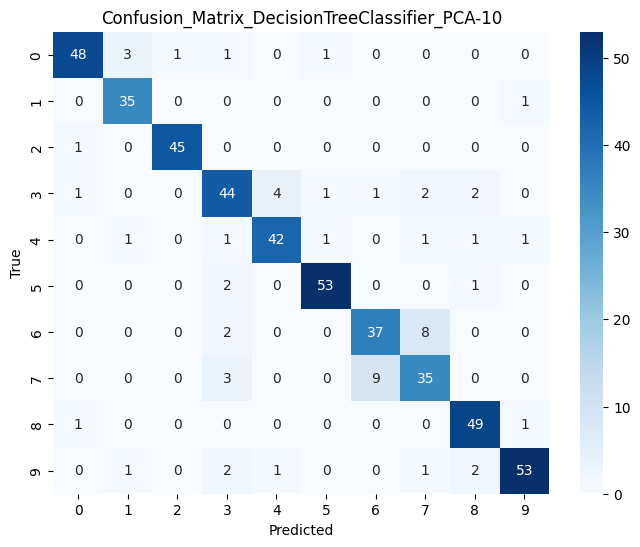

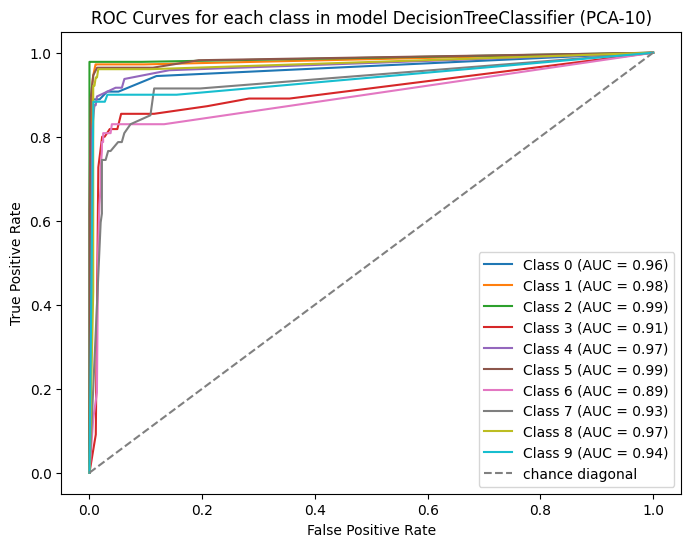

/home/user/shyams-kannada-mnist/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/user/shyams-kannada-mnist/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/user/shyams-kannada-mnist/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

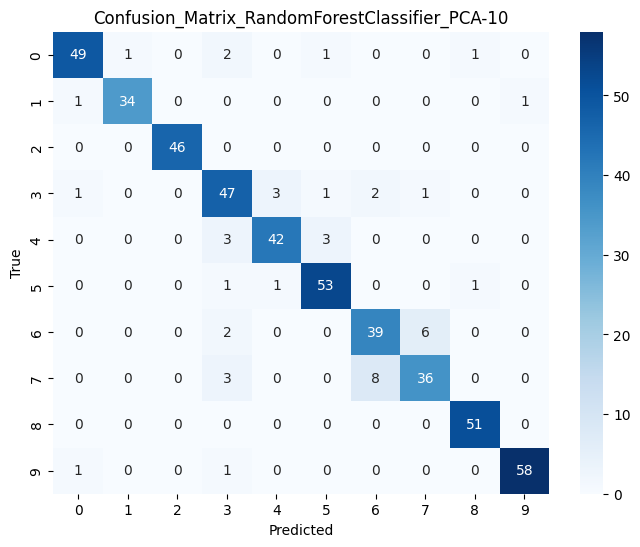

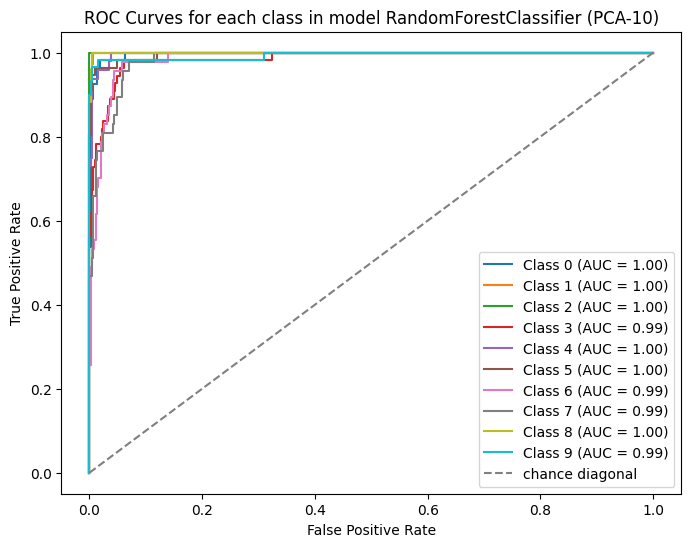

/home/user/shyams-kannada-mnist/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/user/shyams-kannada-mnist/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


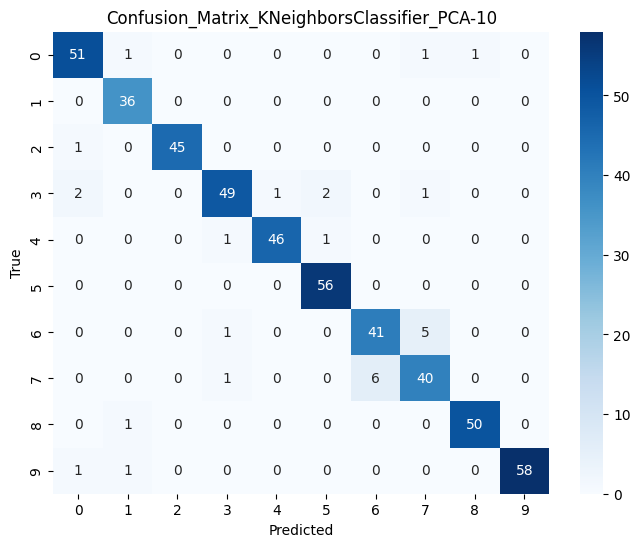

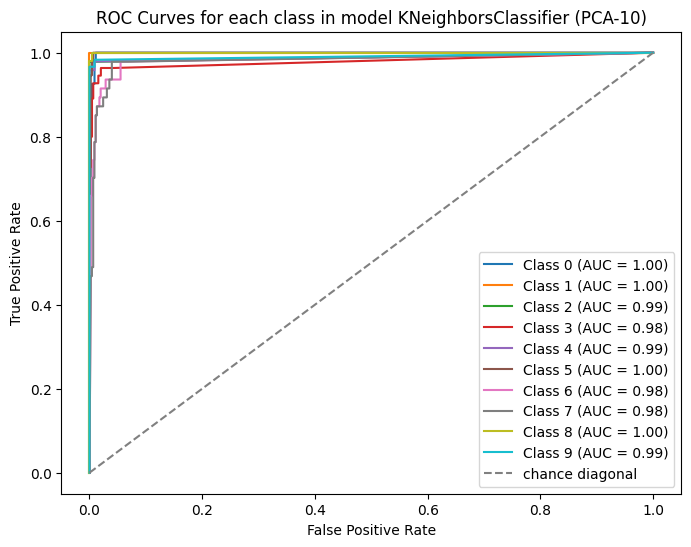

/home/user/shyams-kannada-mnist/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/user/shyams-kannada-mnist/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


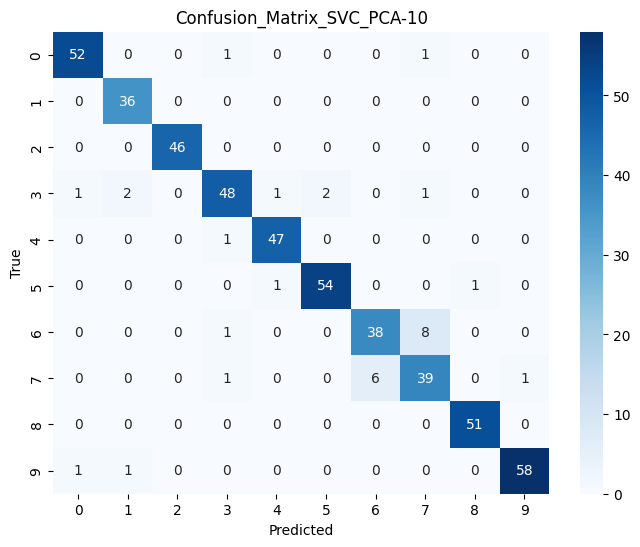

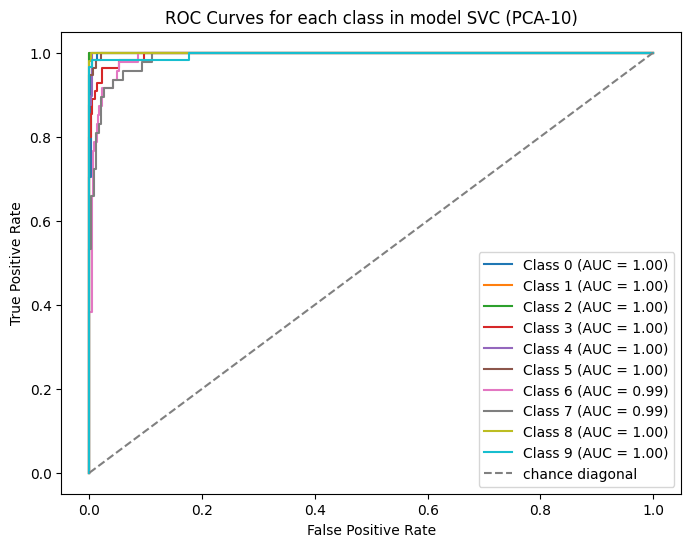

/home/user/shyams-kannada-mnist/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/user/shyams-kannada-mnist/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


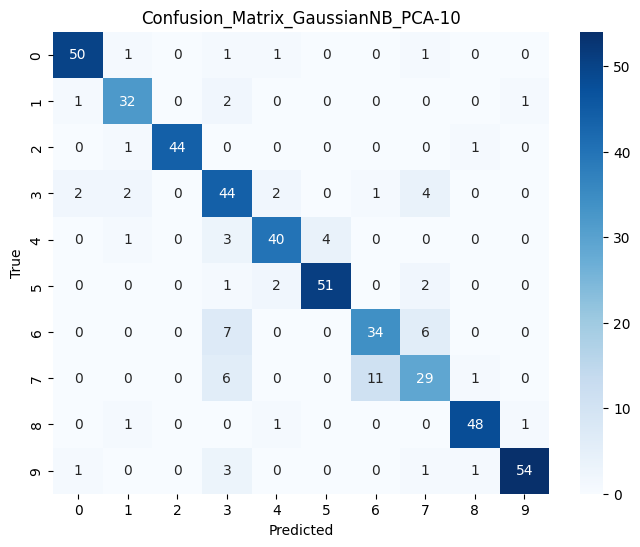

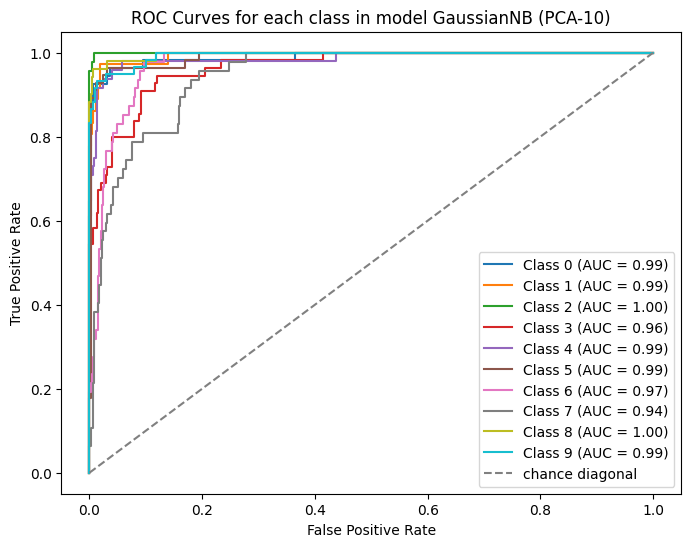

/home/user/shyams-kannada-mnist/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/user/shyams-kannada-mnist/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
/home/user/shyams-kannada-mnist/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

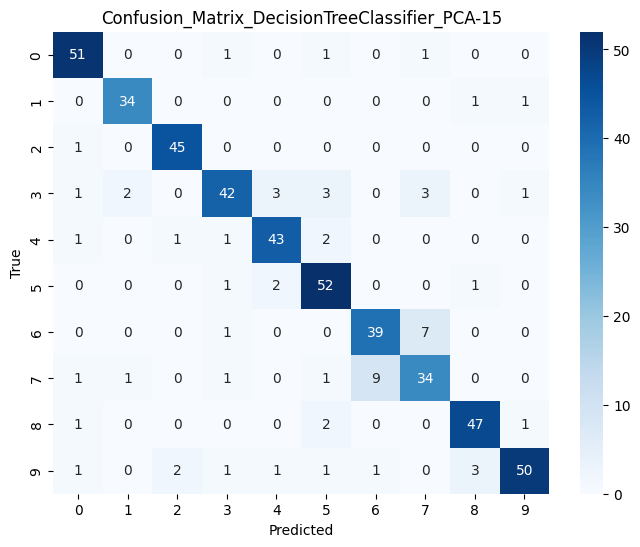

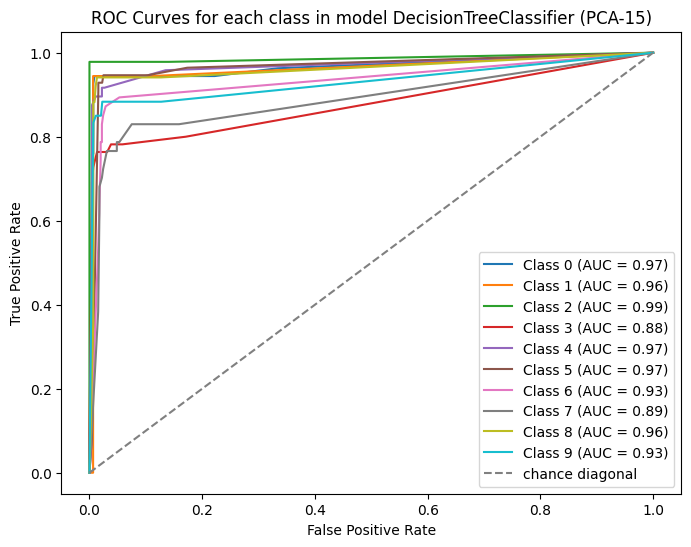

/home/user/shyams-kannada-mnist/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/user/shyams-kannada-mnist/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
/home/user/shyams-kannada-mnist/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

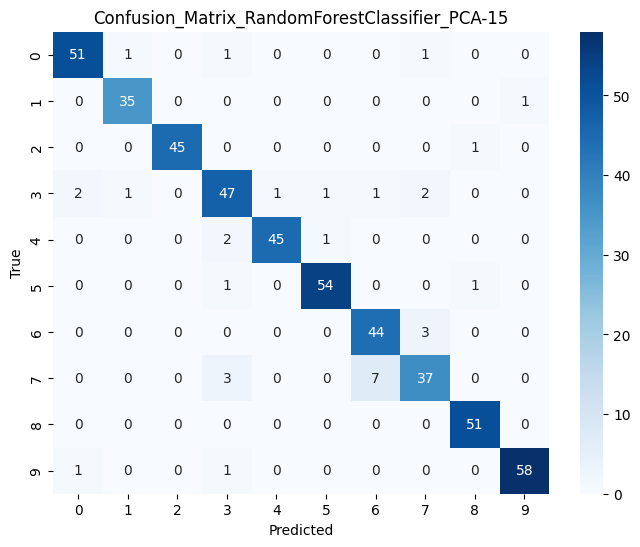

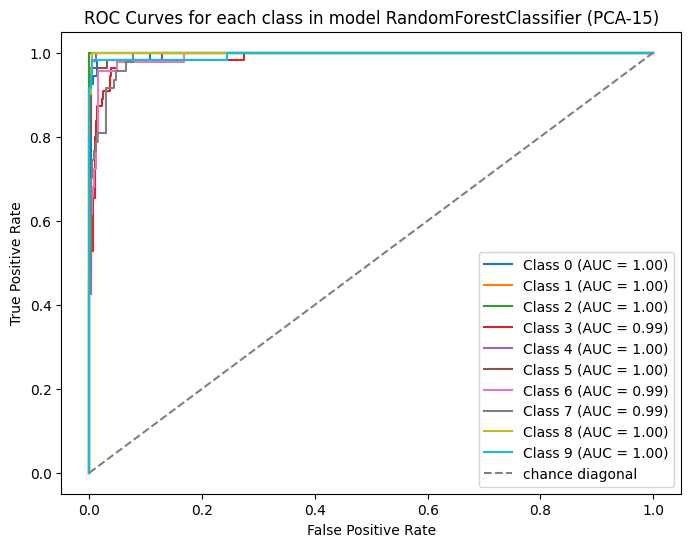

/home/user/shyams-kannada-mnist/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/user/shyams-kannada-mnist/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


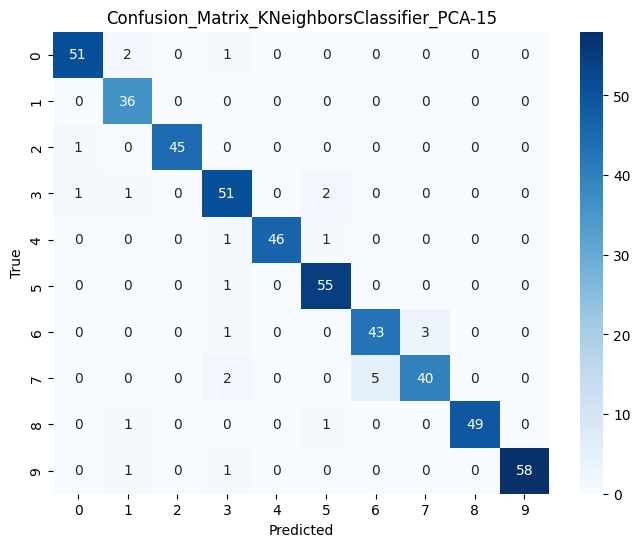

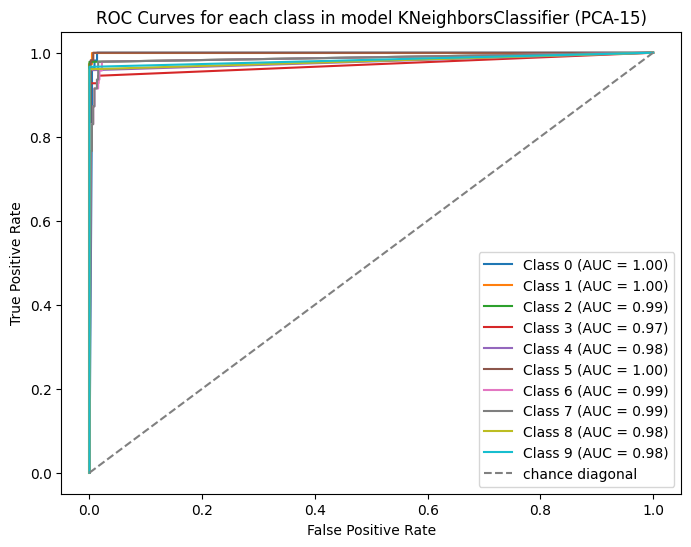

/home/user/shyams-kannada-mnist/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/user/shyams-kannada-mnist/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [38]:

results_list = []

# Step 10: Model Training and Evaluation Loop
mlflow.set_experiment("Kannada_MNIST_Classification")

# Step 11: Data Preprocessing Pipeline with Standard Scaling and PCA
for n_components in [10, 15, 20, 25, 30]:
    scaler = StandardScaler()
    pca_transformer = PCA(n_components=n_components, random_state=42)
    preprocessor = Pipeline([('scaler', scaler), ('pca', pca_transformer)])


    for clf_name, (clf, param_grid) in classifiers.items():
        with mlflow.start_run():

            # Step 4: Log Dataset Size
            mlflow.log_param("dataset_size", len(X_train))

            # Step 12: Log parameters
            mlflow.log_param("PCA components", n_components)
            mlflow.log_param("classifier", clf_name)

            pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', clf)])
            grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='precision_macro')

            start_time = time.time()
            grid_search.fit(X_train, y_train)
            training_time = time.time() - start_time
            mlflow.log_metric("Training time", training_time)

            y_pred = grid_search.predict(X_test)
            y_prob = grid_search.predict_proba(X_test)


            # Evaluate the best model on the validation set
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='macro')
            recall = recall_score(y_test, y_pred, average='macro')
            f1_score_ = f1_score(y_test, y_pred, average='macro')
            roc_auc = roc_auc_score(y_test, y_prob, multi_class="ovr", average="macro")
            report = classification_report(y_test, y_pred)

            # Log metrics and model to MLflow
            mlflow.log_metric("Accuracy", accuracy)
            mlflow.log_metric("Precision", precision)
            mlflow.log_metric("Recall", recall)
            mlflow.log_metric("F1-Score", f1_score_)
            mlflow.log_metric("ROC AUC", roc_auc)
            mlflow.log_metric("ROC AUC", roc_auc)
            mlflow.log_text(report, "classification_report.txt")


            # Log hyperparameters
            for param, value in grid_search.best_params_.items():
                mlflow.log_param(param, value)

            # Log confusion matrix plot as artifact
            confusion_matrix_result = confusion_matrix(y_test, y_pred)
            plot_confusion_matrix(confusion_matrix_result, class_names=np.unique(y_test), title=f'Confusion_Matrix_{clf_name}_PCA-{n_components}')
            # mlflow.log_artifact(f'confusion_matrix_Confusion_Matrix_{clf_name}.png')

            # Log ROC curve plot as artifact
            n_classes = len(np.unique(y_test))
            fpr = dict()
            tpr = dict()
            roc_auc_values = dict()
            for i in range(n_classes):
                fpr[i], tpr[i], _ = roc_curve(y_test == i, y_prob[:, i])
                roc_auc_values[i] = auc(fpr[i], tpr[i])

            roc_auc_data = {
                "fpr": fpr,
                "tpr": tpr,
                "roc_auc": roc_auc_values,
                "class_names": np.unique(y_test),
                "n_classes": n_classes,
            }
            plot_roc_curves(roc_auc_data, clf_name, n_components)
            # mlflow.log_artifact(f'roc_curve_{clf_name}_{n_components}.png')

            # Log experiment-level information
            mlflow.set_experiment_tag("dataset", "Kannada_MNIST")
            mlflow.set_experiment_tag("preprocessing", "StandardScaler")
            mlflow.set_experiment_tag("classifier", clf_name)

            # Save the best model using MLflow's log_model function
            mlflow.sklearn.log_model(grid_search.best_estimator_, "best_model")

            # Append results to the list
            results_list.append({
                "Classifier": clf_name,
                "PCA Components": n_components,
                "Accuracy": accuracy,
                "Precision": precision,
                "Recall": recall,
                "F1-Score": f1_score_,
                "ROC AUC": roc_auc
            })

print("MLflow run completed.")

# Convert the list of dictionaries to a DataFrame
results_df = pd.DataFrame(results_list)




In [ ]:
# Results of the experiment
results_df

,Classifier,PCA Components,Accuracy,Precision,Recall,F1-Score,ROC AUC
0,DecisionTreeClassifier,10,0.784,0.797182,0.784,0.785862,0.905536
1,RandomForestClassifier,10,0.886,0.887192,0.886,0.885645,0.991891
2,KNeighborsClassifier,10,0.902,0.905699,0.902,0.902292,0.970092
3,SVC,10,0.906,0.908801,0.906,0.906076,0.995730
4,DecisionTreeClassifier,15,0.806,0.819982,0.806,0.808115,0.920002
5,RandomForestClassifier,15,0.924,0.925222,0.924,0.924137,0.994544
6,KNeighborsClassifier,15,0.942,0.945012,0.942,0.941955,0.985028
7,SVC,15,0.928,0.930296,0.928,0.928036,0.997764
8,DecisionTreeClassifier,20,0.796,0.812225,0.796,0.798030,0.917509
9,RandomForestClassifier,20,0.918,0.921273,0.918,0.918138,0.995584


In [ ]:
# Step 12: Set up the ngrok tunnel to the MLflow UI
!ngrok authtoken 2ZjwOwRMWe1xdOQuhwti9eQTXBA_45bBvrKJqeZy7foGQgYWA

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
# Start MLflow UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &")

# Use ngrok to create a public URL for the MLflow UI
ngrok_tunnel_mlflow = ngrok.connect(addr="5000", proto="http", bind_tls=True)

# Print the public URL for MLflow UI
print("MLflow UI can be accessed at:", ngrok_tunnel_mlflow.public_url)

MLflow UI can be accessed at: https://d395-34-74-239-51.ngrok-free.app


In [ ]:

# Step 13: Start Streamlit in the background
get_ipython().system_raw('nohup streamlit run /content/app.py &')

# Use ngrok to create a public URL for the Streamlit app
ngrok_tunnel_streamlit = ngrok.connect(addr="8501", proto="http", bind_tls=True)

# Print the public URL for Streamlit app
print("Streamlit app can be accessed at:", ngrok_tunnel_streamlit.public_url)

MLflow UI can be accessed at: https://a37d-34-125-199-155.ngrok-free.app
Streamlit app can be accessed at: https://3642-34-125-199-155.ngrok-free.app


In [ ]:
X_train = load_data(train_file_path)
X_test = load_data(test_file_path)
y_train = load_data(label_train_file_path)
y_test = load_data(label_test_file_path)


# Step 8: Flatten the image data
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Log the size of the training dataset
mlflow.log_param("train_dataset_size", len(X_train))

# Log the size of the testing dataset
mlflow.log_param("test_dataset_size", len(X_test))

# Preprocess the data
# Initialize PCA with n_components=30
pca_transformer_best = PCA(n_components=30, random_state=42)

# Define the preprocessing pipeline with the best PCA components
preprocessor_best = Pipeline([
    ('scaler', MinMaxScaler()),
    ('pca', pca_transformer_best)
])

# Apply the preprocessing pipeline to the entire training dataset
X_train_preprocessed = preprocessor_best.fit_transform(X_train)

# Initialize the Support Vector Classifier
best_svc_model = SVC(probability=True, C=1, kernel='rbf')
# Train the SVC model on the preprocessed training data
best_svc_model.fit(X_train_preprocessed, y_train)

# Save the trained model using MLflow's log_model function
mlflow.sklearn.log_model(best_svc_model, "best_svc_model")


In [ ]:
# Step 12: Set up the ngrok tunnel to the MLflow UI
!ngrok authtoken 2ZjwOwRMWe1xdOQuhwti9eQTXBA_45bBvrKJqeZy7foGQgYWA  # Replace with your ngrok auth token

# Start MLflow UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &")

# Use ngrok to create a public URL for the MLflow UI
ngrok_tunnel_mlflow = ngrok.connect(addr="5000", proto="http", bind_tls=True)

# Print the public URL for MLflow UI
print("MLflow UI can be accessed at:", ngrok_tunnel_mlflow.public_url)


# Step 13: Start Streamlit in the background
get_ipython().system_raw('nohup streamlit run /content/app.py &')

# Use ngrok to create a public URL for the Streamlit app
ngrok_tunnel_streamlit = ngrok.connect(addr="8501", proto="http", bind_tls=True)

# Print the public URL for Streamlit app
print("Streamlit app can be accessed at:", ngrok_tunnel_streamlit.public_url)

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
MLflow UI can be accessed at: https://173c-34-74-239-51.ngrok-free.app
Streamlit app can be accessed at: https://c84c-34-74-239-51.ngrok-free.app


In [ ]:


X_train = load_data(train_file_path)
X_test = load_data(test_file_path)
y_train = load_data(label_train_file_path)
y_test = load_data(label_test_file_path)

# Step 8: Flatten the image data
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Log the size of the training dataset
mlflow.log_param("train_dataset_size", len(X_train))

# Log the size of the testing dataset
mlflow.log_param("test_dataset_size", len(X_test))

# Preprocess the data
# Initialize PCA with n_components=30
pca_transformer_best = PCA(n_components=30, random_state=42)

# Define the preprocessing pipeline with the best PCA components
preprocessor_best = Pipeline([
    ('scaler', MinMaxScaler()),
    ('pca', pca_transformer_best)
])

# Apply the preprocessing pipeline to the entire training dataset
X_train_preprocessed = preprocessor_best.fit_transform(X_train)

# Initialize the Support Vector Classifier
best_svc_model = SVC(probability=True, C=1, kernel='rbf')
# Train the SVC model on the preprocessed training data
best_svc_model.fit(X_train_preprocessed, y_train)

# Save the trained model using MLflow's log_model function
mlflow.sklearn.log_model(best_svc_model, "best_svc_model")




In [ ]:
# Start MLflow UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &")

# Use ngrok to create a public URL for the MLflow UI
ngrok_tunnel_mlflow = ngrok.connect(addr="5000", proto="http", bind_tls=True)

# Print the public URL for MLflow UI
print("MLflow UI can be accessed at:", ngrok_tunnel_mlflow.public_url)

MLflow UI can be accessed at: https://f730-34-106-203-137.ngrok-free.app


In [ ]:
model_path = "/content/mlruns/696447561508447482/af5a18a2ec4a4acf9aefacc91c79303b/artifacts/best_svc_model/MLmodel"

In [ ]:
# Use ngrok to create public URLs for the MLflow UI and Streamlit app.
ngrok_tunnel_mlflow = ngrok.connect(addr="5000", proto="http", bind_tls=True)
ngrok_tunnel_streamlit = ngrok.connect(addr="8501", proto="http", bind_tls=True)

# Print the public URLs
print("MLflow UI can be accessed at:", ngrok_tunnel_mlflow.public_url)
print("Streamlit app can be accessed at:", ngrok_tunnel_streamlit.public_url)

MLflow UI can be accessed at: https://228a-34-106-203-137.ngrok-free.app
Streamlit app can be accessed at: https://a0a6-34-106-203-137.ngrok-free.app


In [ ]:
# Step 13: Start Streamlit in the background
get_ipython().system_raw('nohup streamlit run app.py &')

# Use ngrok to create a public URL for the Streamlit app
ngrok_tunnel_streamlit = ngrok.connect(addr="8501", proto="http", bind_tls=True)

# Print the public URL for Streamlit app
print("Streamlit app can be accessed at:", ngrok_tunnel_streamlit.public_url)

Streamlit app can be accessed at: https://3f5d-34-74-239-51.ngrok-free.app


In [ ]:
import streamlit as st
import mlflow
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

# Load the MLflow model
model_uri = '/content/mlruns/314269285163105919/965390fbbe4a4e1a9694497d6e4e2ff7/artifacts/best_svc_model'

loaded_model = mlflow.sklearn.load_model(model_uri)

# Create a Streamlit web application
def main():
    st.title("Multiclass Image Classification with SVC Model")

    # Upload an image file
    uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

    if uploaded_file is not None:
        # Display the uploaded image
        image = Image.open(uploaded_file)
        st.image(image, caption="Uploaded Image.", use_column_width=True)

        # Preprocess the uploaded image
        input_image = preprocess_input_image(image)

        # Make predictions using the loaded model
        prediction = loaded_model.predict(input_image)
        probabilities = loaded_model.predict_proba(input_image)

        # Display the prediction results
        st.subheader("Prediction")
        st.write(f"The predicted class is: {prediction[0]}")

        # Display probabilities for each class
        st.subheader("Prediction Probabilities")
        for i, prob in enumerate(probabilities[0]):
            st.write(f"Class {i}: {prob:.4f}")

# Function to preprocess the input image
def preprocess_input_image(image):
    # Resize the image to match the expected input size
    resized_image = image.resize((28, 28))

    # Convert the image to a NumPy array
    image_array = np.array(resized_image)

    # Flatten the image data
    flattened_image = image_array.reshape(1, -1)

    # Apply the same preprocessing pipeline
    # Initialize PCA with n_components=30
    pca_transformer_best = PCA(n_components=30, random_state=42)

    # Define the preprocessing pipeline with the best PCA components
    preprocess_image = Pipeline([
        ('scaler', MinMaxScaler()),
        ('pca', pca_transformer_best)
    ])

    # Apply preprocessing
    preprocessed_image = preprocess_image.transform(flattened_image)

    return preprocessed_image

In [ ]:
# Stop ngrok
!pkill ngrok

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the training images from the npz file
train_data = np.load(train_file_path)
X_train = train_data['arr_0']

# Create a directory to save the images (adjust the directory path as needed)
save_directory = "/content/downloaded_images"
os.makedirs(save_directory, exist_ok=True)

# Save the first 10 images from the training set
num_images_to_save = 10
for i in range(num_images_to_save):
    image = X_train[i]
    image_path = os.path.join(save_directory, f"image_{i}.png")
    plt.imsave(image_path, image, cmap='gray')

# Display the saved images paths
print(f"{num_images_to_save} images saved to {save_directory}")


10 images saved to /content/downloaded_images
